<a href="https://colab.research.google.com/github/UNIST-LIM-Lab-course/transformer_assignment-xiyanafiguera/blob/main/transformer_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Assignment 

The task objective is to code seq2seq model using transformer
* An assignment part is denoted by (Assingment) 

* Grading criteria: Points are given if all your code in this notebook is runnable and the final ppl is lower than 100 

* Points are not given if the testing cell at the end of the notebook is modified or extra cells (including text) are added after the last cell. Do not change N_EPOCHS for testing efficiently.

* Testing your model with the testing cell is recommended. 

* Please do not re-use the code from the example code. You have to write the code yourself.

# Assignment List

* 2.3 (Assignment) Make Encoder
* 2.4 (Assignment) Make EncoderLayer
* 2.5 (Assignment) Make Decoder
* 2.6 (Assignment) Make DecoderLayer
* 2.7 (Assignment) Make Seq2seq

#1. Preparing the Data



In [1]:
pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 14.3 MB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

from spacy.lang.en import English
from spacy.lang.de import German


spacy_en=English()
spacy_de=German()

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

BATCH_SIZE = 128


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.53MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.61MB/s]

downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.58MB/s]


##1.1 Check whether GPU is avaliable

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

batch = next(iter(train_iterator))
src = batch.src
trg = batch.trg 
print(src.shape)
print(trg.shape)

torch.Size([128, 28])
torch.Size([128, 31])


#2. Transformer 

## 2.1 MultiheadAttentionLayer

---



In [5]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)      
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)   
        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)
        

        
        return x, attention

## 2.2 PositionwiseFeedforwardLayer

* The positionwise feed-forward network transforms the representation at all the sequence positions using the same MLP.

In [6]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):    
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        
        return x

## 2.3(Assignment) Make Encoder
* Fill out `def forward` of encoder according to #(TODO:Assignment).

* It means you should fill out the right side following the hint denoted by # comment 


* Don't change the rest of the code except for 'def forward'





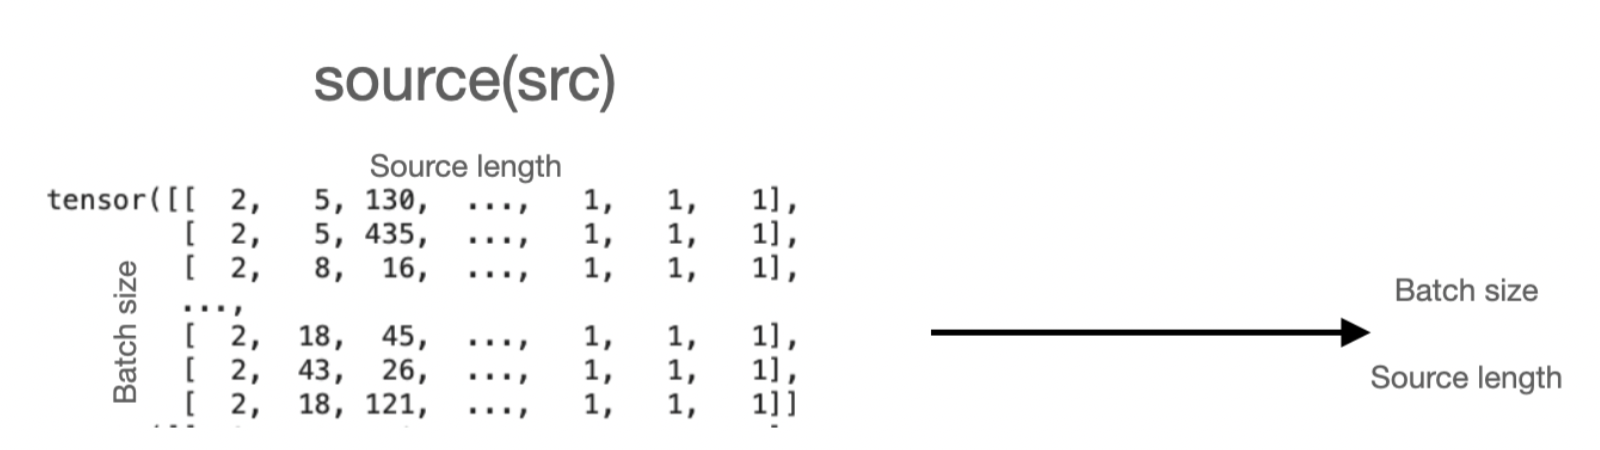

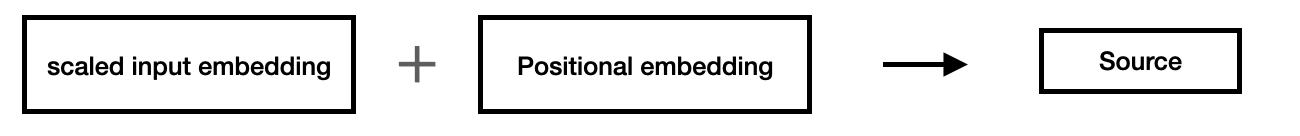

In [7]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        batch_size = src.shape[0] #(TODO:Assignment) Get informationfrom src
        src_len  = src.shape[1] #(TODO:Assignment) Get informationfrom src
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)) #(TODO:Assignment) Sum scaled 'tok_embedding' and 'pos_embedding' then apply dropout.

        
        for layer in self.layers:
            src = layer(src, src_mask)
            
            
        return src

##2.4 (Assignment) Make EncoderLayer

* Fill out `def forward` of Encoder layer according to the description below.

* Don't change the rest of the code except for 'def forward'



```
1) Input the source sentence

2) Pass its mask into the multi-head attention layer 

3) Pass it through a position-wise feedforward layer

4) Apply dropout, a residual connection and then layer normalization

```





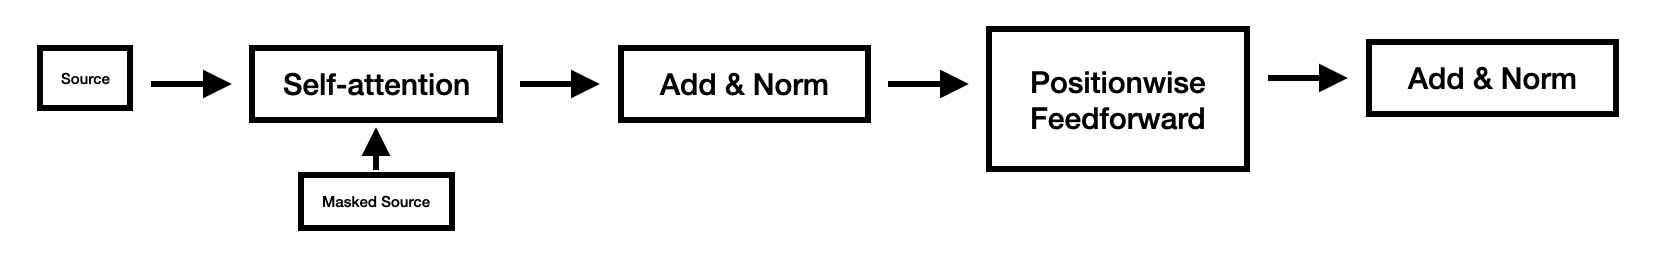

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #(TODO:Assignment)
        # 1) Apply self_attention
        # 2) Perform dropout, residual connection and layer norm
        # 3) Pass source into positionwise feedforward network
        # 4) Apply dropout and residula and then ff layer normalization 

        sorc, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(sorc))
        sorc = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(sorc))

        
        return src

## (Assignment) 2.5 Make Decoder

* Fill out `def forward` of encoder according to #(TODO:Assignment).

* It means you should fill out the right side following the hint denoted by # comment

* Don't change the rest of the code except for 'forward'



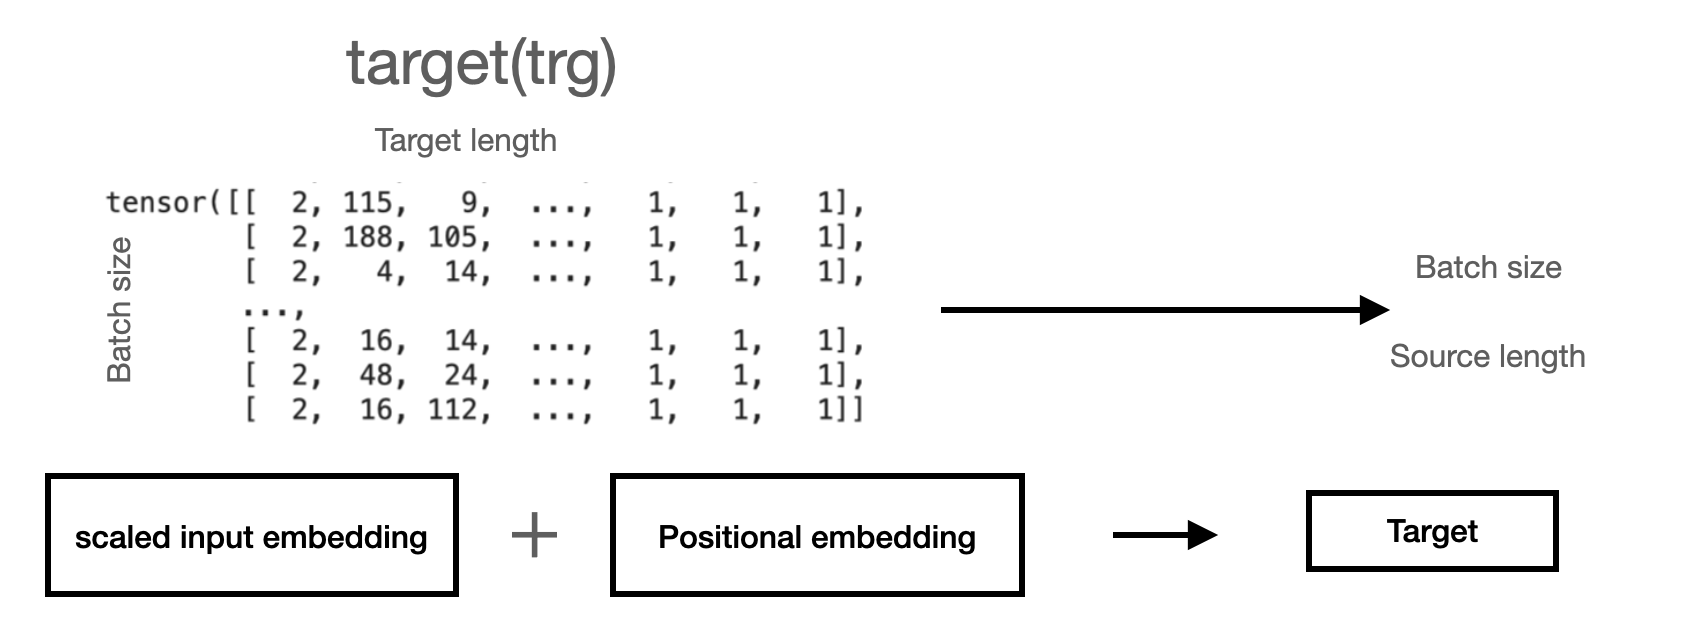

In [9]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size = trg.shape[0] #(TODO:Assignment) Get information from trg 
        trg_len = trg.shape[1] #(TODO:Assignment) Get information from trg 
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)  
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos)) #(TODO:Assignment) Sum scaled 'tok_embedding' and 'pos_embedding' then apply dropout.
     
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
 

        output = self.fc_out(trg) #(TODO:Assignment) Estimate output from fc_out 

            
        return output, attention

## (Assignment) 2.6 Make DecoderLayer

* Fill out `def forward` of Make Encoder layer according to the description below.

* Don't change the rest of the code except for 'def forward'


```
1) First perform self-attentionby using the decoder representation 

2) Make dropout, residual connection and layer normalization 

3) Perform self-encoder_attention by using the decoder representation

4) Make dropout, residual connection and layer normalization 

5) Pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

```



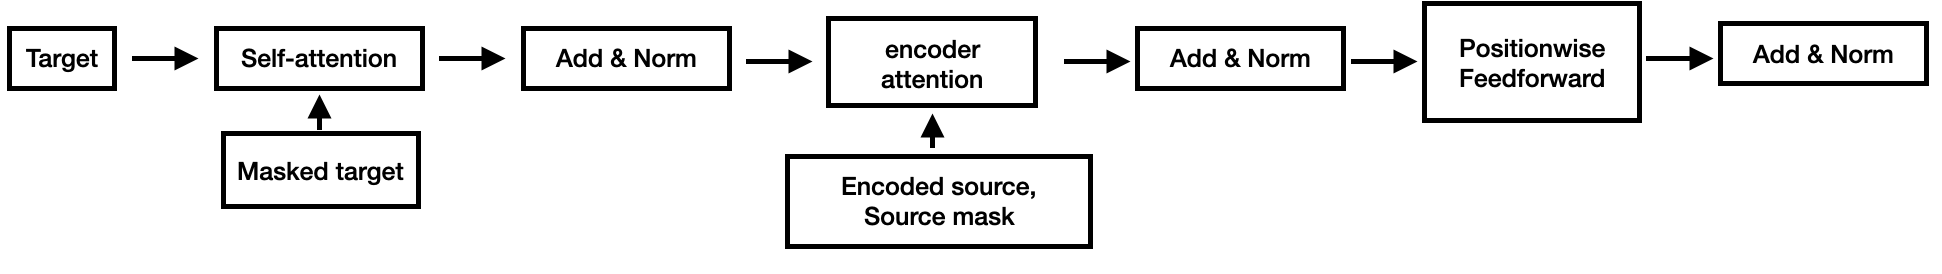

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        #(TODO:Assignment)
        # 1) Apply self attention
        # 2) Perform dropout, residual connection and layer norm
        # 3) Apply encoder attention
        # 4) Perform dropout, residual connection and layer norm
        # 5) Pass positionwise feedforward
        # 6) Make dropout, residual and layer norm

        trgx, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(trgx))
        trgx, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(trgx))
        trgx = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(trgx))
        
        return trg, attention

## (Assignment) 2.7 Make Seq2seq
* Fill out `def forward` of the seq2seq module which encapsulates the encoder and decoder

* Don't change the rest of the code except for 'forward'


* Make seq2seq model according to the description below.



```
1) Make source mask, target mask by 'def mask_trg_mask'. 

2) Apply the encoder to source and source mask

3) Apply the decoder to target, encoded source and masked objects.

```





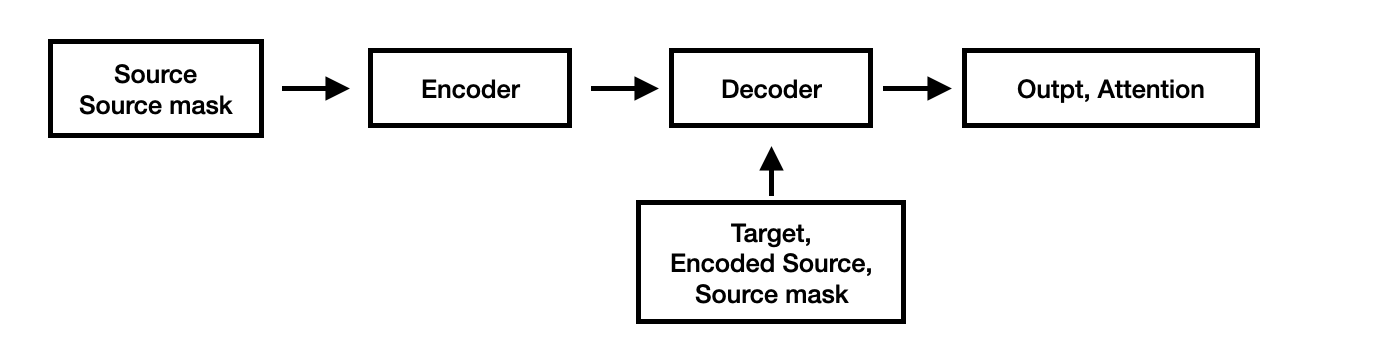

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask


    def forward(self, src, trg):
        #(TODO:Assignment)
        # 1) Estimate source mask and target mask 
        # 2) Apply encoder into sorce and sorce mask 
        # 3) Get output, attention from decoder 

        mk_sorc = self.make_src_mask(src)
        mk_trgx = self.make_trg_mask(trg)
        encd_sorc = self.encoder(src, mk_sorc)
        output, attention = self.decoder(trg, encd_sorc, mk_trgx, mk_sorc)

        return output, attention

# DO NOT CHANGE THE CODE ATER 2.7 Make Seq2Seq.

## 3. Training the Seq2Seq Model



In [12]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [13]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [15]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [16]:
model.apply(initialize_weights);

In [17]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [18]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [19]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
N_EPOCHS = 2
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 19s
	Train Loss: 4.243 | Train PPL:  69.644
	 Val. Loss: 3.016 |  Val. PPL:  20.407
Epoch: 02 | Time: 0m 18s
	Train Loss: 2.816 | Train PPL:  16.707
	 Val. Loss: 2.305 |  Val. PPL:  10.028


In [23]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.312


In [24]:
ppl = math.exp(test_loss)
print(ppl)

10.099157036751416
